In [1]:
import numpy as np
import scipy
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import geopandas as gpd

matplotlib.rcParams['font.family'] = 'serif'


In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [3]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.set_crs(sub_world.crs)
sub_cities_list = list(cities.sjoin(sub_world, how = 'right')['name_left'])[1:]
sub_cities = cities[cities['name'].isin(sub_cities_list)]

In [4]:
def get_ucdp_prio():

    with open(f'/media/simon/Seagate Expansion Drive/Bodies_dfs/PRIO/full_interpl_df_exposure.pkl', 'rb') as file:
        ucdp_prio = pickle.load(file)

    return(ucdp_prio)

ucdp_prio = get_ucdp_prio()

In [5]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df_full = pickle.load(file)

# distance days is distance hours....!!!!!!!!!!!!!!!!!!
bodies_df = bodies_df_full[(bodies_df_full['distance_days'] <= 48) | (bodies_df_full['location_annot'] == 1)].copy() # only locations you are certain of

bodies_df.loc[bodies_df['city'] == 'nan', 'city'] = 'other'

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")

In [6]:
list_of_features = ['person_mean', 'uniformed_mean', 'firearm_mean', 'militarized_mean', 'damaged_property_mean', 'mass_protest_mean']
bodies_df_full[list_of_features].mean(axis = 0)

person_mean              2.190914
uniformed_mean           0.330330
firearm_mean             0.067397
militarized_mean         0.129405
damaged_property_mean    0.217529
mass_protest_mean       -0.117367
dtype: float64

In [7]:
bodies_df_full[list_of_features].std(axis = 0)

person_mean              2.152298
uniformed_mean           0.744114
firearm_mean             0.264455
militarized_mean         0.379169
damaged_property_mean    0.572782
mass_protest_mean        0.266437
dtype: float64

In [8]:
bodies_df_full[list_of_features].median(axis = 0)

person_mean              1.600000
uniformed_mean           0.000000
firearm_mean             0.000000
militarized_mean         0.046097
damaged_property_mean    0.117846
mass_protest_mean       -0.145784
dtype: float64

In [9]:
for i in list_of_features:
    mask = bodies_df_full[i] >= 1
    r = mask.sum() / mask.shape[0]

    print(f'{i}: {r}')

person_mean: 0.7398809367361422
uniformed_mean: 0.12922832286382632
firearm_mean: 0.02365495308434305
militarized_mean: 0.021887402423318526
damaged_property_mean: 0.11990432885641443
mass_protest_mean: 6.570820301206403e-05


In [10]:
bodies_df_full.shape

(152188, 194)

In [11]:
bodies_df_full[list_of_features][mask].mean(axis = 0)

person_mean              2.600000
uniformed_mean           0.040000
firearm_mean             0.040000
militarized_mean        -0.196388
damaged_property_mean   -0.077985
mass_protest_mean        1.055404
dtype: float64

In [12]:
print((bodies_df_full['publication'] == 'Raw').sum())
print((bodies_df_full['publication'] == 'Raw').sum()/bodies_df_full.shape[0])

print((bodies_df_full['publication'] == 'Submitted').sum())
print((bodies_df_full['publication'] == 'Submitted').sum()/bodies_df_full.shape[0])

print((bodies_df_full['publication'] == 'Published').sum())
print((bodies_df_full['publication'] == 'Published').sum()/bodies_df_full.shape[0])

146686
0.9638473467027624
5005
0.03288695560753804
497
0.0032656976896995823


In [13]:
bodies_df[bodies_df['city'] != 'other']

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean,coords
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,15.90000,1020.000,0.0,58.67639,44.3787992/33.3024309
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,15.90000,1020.000,0.0,58.67639,44.3787992/33.3024309
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,15.90000,1020.000,0.0,58.67639,44.3787992/33.3024309
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,15.87917,1014.583,0.0,415.26140,41.03786/34.427567
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,15.87917,1014.583,0.0,415.26140,41.046437/34.390889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152183,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,True,False,15.90000,1020.000,0.0,168.32170,44.152788642134524/34.00131295
152184,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,True,False,15.90000,1020.000,0.0,168.32170,44.152788642134524/34.00131295
152185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,15.90000,1020.000,0.0,168.32170,44.152788642134524/34.00131295
152186,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,False,False,False,True,False,15.90000,1020.000,0.0,168.32170,44.152788642134524/34.00131295


In [14]:
149322/152188

0.9811680290167425

In [15]:
bodies_df_full

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,pasture_ih_observed,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.87917,1014.583,0.0,415.26140
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.87917,1014.583,0.0,415.26140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152183,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152184,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152186,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170


In [16]:
((bodies_df_full['location_annot'] == 1) & (bodies_df_full['city'] != 'nan')).mean()

0.10571135700580861

In [17]:
(((bodies_df_full['location_annot'] == 1) & (bodies_df_full['city'] != 'nan')) | ((bodies_df_full['distance_days'] <= 24) & (bodies_df_full['city'] != 'nan'))).mean()

0.9717914684469209

In [18]:
(((bodies_df_full['location_annot'] == 1) & (bodies_df_full['city'] != 'nan')) | ((bodies_df_full['distance_days'] <= 48) & (bodies_df_full['city'] != 'nan'))).mean()

0.9811680290167425

In [19]:
0.7389084553315636 - 0.10571135700580861


0.633197098325755

In [20]:
((bodies_df_full['location_annot'] == 1) | (bodies_df_full['distance_days'] <= 14)).mean()

0.9805766551896339

In [21]:
bodies_df_full['city'].unique().shape

(33,)

# Uncertainties

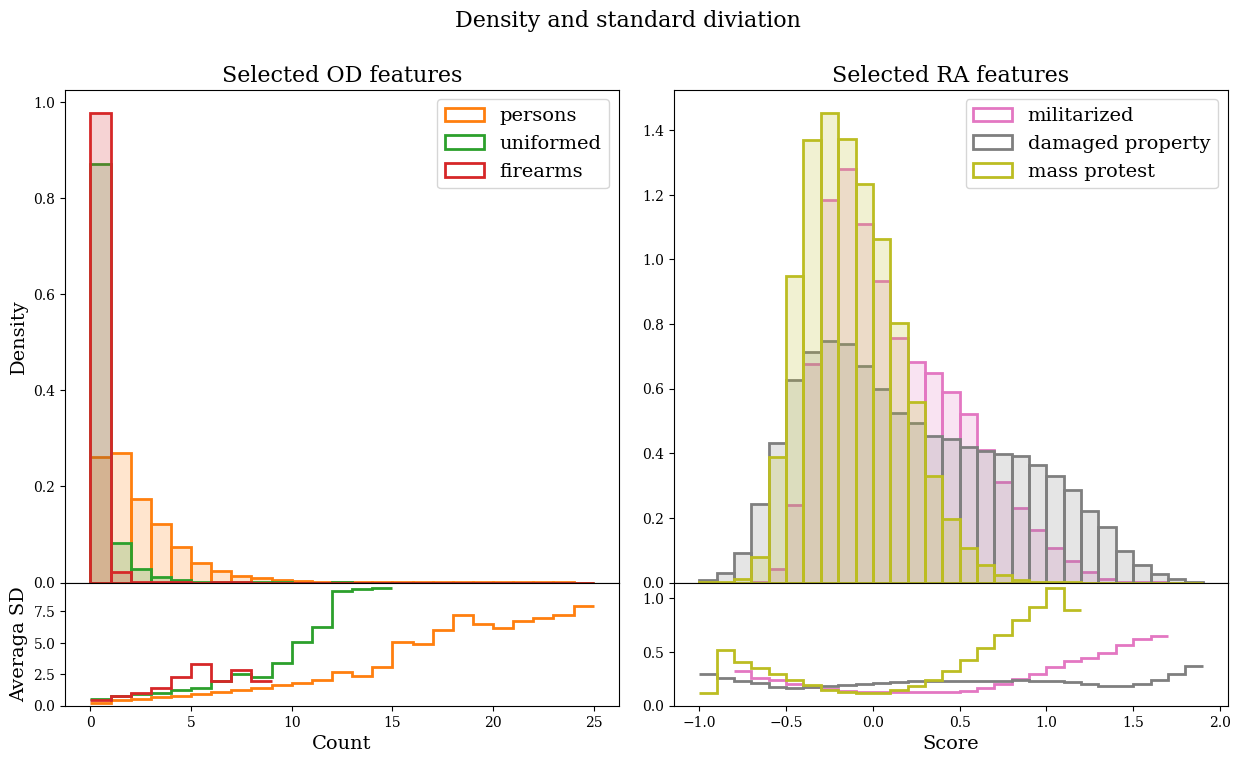

In [22]:

def std_plot(axs, features, f_range, color):

    bodies_temp = bodies_df[features].copy()

    bodies_temp['std'] = bodies_temp[features[1:]].std(axis = 1)
    bodies_temp

    std = bodies_temp.groupby(pd.cut(bodies_temp[features[0]], f_range)).mean()['std'].values

    #axs.plot(f_range[:-1], std, 'o-', color=color)
    #axs.bar(f_range[:-1], std, color=color, width =f_range[2]- f_range[1], alpha = 0.2)
    #axs.bar(f_range[:-1], std, fc = 'None', ec=color, width =f_range[2]- f_range[1], alpha = 1,  lw=2)

    axs.stairs(std, f_range, fc = 'None', ec=color, alpha = 1,  lw=2, baseline=None)


# -------------------------------------------------------------------------------------------------

# plt.figure(figsize = [15,8])
fig, axs = plt.subplots(2,2,figsize=(15,8), gridspec_kw={'height_ratios': [4, 1]})

od_range = np.arange(0,26, 1)
ra_range = np.arange(-1,2, .1)

#plt.subplot(2,2,1)
fig.subplots_adjust(hspace=0, wspace=0.1)
axs[0, 0].set_anchor('SE')
axs[1, 0].set_anchor('NE')
axs[0, 1].set_anchor('SW')
axs[1, 1].set_anchor('NW')

axs[0,0].hist(bodies_df['person_mean'], fc = 'C1', alpha = 0.2, bins = od_range, density = True)
axs[0,0].hist(bodies_df['person_mean'], fc = "None", ec = 'C1',  lw=2, bins = od_range, density = True, label = 'persons')

axs[0,0].hist(bodies_df['uniformed_mean'], color = 'C2', alpha = 0.2, bins = od_range, density = True)
axs[0,0].hist(bodies_df['uniformed_mean'], fc = "None", ec = 'C2',  lw=2, bins = od_range, density = True, label = 'uniformed')

axs[0,0].hist(bodies_df['firearm_mean'], color = 'C3', alpha = 0.2, bins = od_range, density = True)
axs[0,0].hist(bodies_df['firearm_mean'], fc = "None", ec = 'C3',  lw=2, bins = od_range, density = True, label = 'firearms')
axs[0,0].set_ylabel('Density', fontsize = 14)
axs[0,0].set_xticks([])
axs[0,0].legend(fontsize = 14)
axs[0,0].set_title('Selected OD features', fontsize = 16)

#plt.subplot(2,2,2)

axs[0,1].hist(bodies_df['militarized_mean'], color = 'C6', alpha = 0.2, bins = ra_range, density = True)
axs[0,1].hist(bodies_df['militarized_mean'], fc = "None", ec = 'C6',  lw=2, bins = ra_range, density = True, label = 'militarized')


axs[0,1].hist(bodies_df['damaged_property_mean'], color = 'C7', alpha = 0.2, bins = ra_range, density = True)
axs[0,1].hist(bodies_df['damaged_property_mean'], fc = "None", ec = 'C7',  lw=2, bins = ra_range, density = True, label = 'damaged property')

axs[0,1].hist(bodies_df['mass_protest_mean'], color = 'C8', alpha = 0.2, bins = ra_range, density = True)
axs[0,1].hist(bodies_df['mass_protest_mean'], fc = "None", ec = 'C8',  lw=2, bins = ra_range, density = True, label = 'mass protest')
axs[0,1].set_xticks([])
axs[0,1].legend(fontsize = 14)
axs[0,1].set_title('Selected RA features', fontsize = 16)

#axs[1].subplot(2,2,3)

std_plot(axs[1,0], ['person_mean', 'person_fasterR50', 'person_fasterR101', 'person_fasterX101', 'person_retinaR50', 'person_retinaR101'], od_range, 'C1')
std_plot(axs[1,0], ['uniformed_mean', 'uniformed_fasterR50', 'uniformed_fasterR101', 'uniformed_fasterX101', 'uniformed_retinaR50', 'uniformed_retinaR101'], od_range, 'C2')
std_plot(axs[1,0], ['firearm_mean', 'firearm_fasterR50', 'firearm_fasterR101', 'firearm_fasterX101', 'firearm_retinaR50', 'firearm_retinaR101'], od_range, 'C3')
axs[1,0].set_ylabel('Averaga SD', fontsize = 14)
axs[1,0].set_xlabel('Count', fontsize = 14)

#plt.subplot(2,2,4)

std_plot(axs[1,1], ['militarized_mean', 'militarized_swin', 'militarized_convnext'], ra_range, 'C6')
std_plot(axs[1,1], ['damaged_property_mean', 'damaged_property_swin', 'damaged_property_convnext'], ra_range, 'C7')
std_plot(axs[1,1], ['mass_protest_mean', 'mass_protest_swin', 'mass_protest_convnext'], ra_range, 'C8')
axs[1,1].set_xlabel('Score', fontsize = 14)

plt.suptitle("Density and standard diviation", fontsize = 16)


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/dist0.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [23]:
#features = ['uniformed_mean', 'uniformed_fasterR50', 'uniformed_fasterR101', 'uniformed_fasterX101', 'uniformed_retinaR50', 'uniformed_retinaR101']
features = ['person_mean', 'person_fasterR50', 'person_fasterR101', 'person_fasterX101', 'person_retinaR50', 'person_retinaR101']

bodies_temp = bodies_df[features].copy()

bodies_temp['std'] = bodies_temp[features[1:]].std(axis = 1) # this measure should ba deed to the 1.5
bodies_temp

std = bodies_temp.groupby(pd.cut(bodies_temp[features[0]], od_range)).mean()['std'].values

print(list(zip(od_range,std)))

[(0, 0.2511879032285122), (1, 0.4404210779396419), (2, 0.5286612637911056), (3, 0.658384024679578), (4, 0.7841406313665579), (5, 0.9345136459066238), (6, 1.075972167616811), (7, 1.27025217709014), (8, 1.4410106744150837), (9, 1.6400917709450618), (10, 1.8169005248744687), (11, 2.060039304580151), (12, 2.6383233721558157), (13, 2.358895385840889), (14, 3.045307150213345), (15, 5.049556481319008), (16, 4.887475690323604), (17, 5.975289911781791), (18, 7.201018489775409), (19, 6.47324383638661), (20, 6.1729517262172156), (21, 6.717477616013814), (22, 6.932934068043357), (23, 7.201253762390855), (24, 7.895534566382651)]


# In Space:

In [24]:
def get_coords_gpd( feature, bodies_df = bodies_df, sub_world = sub_world):

    sub_df = bodies_df[bodies_df['city'] != 'other']

    if feature == None:
        unique_coords = sub_df.groupby('coords').count()

    else:
        unique_coords = sub_df[sub_df[feature] >= 1].groupby('coords').count()
    
    unique_coords = unique_coords['person_mean'].reset_index() # the feature does not matter here
    unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)

    unique_coords['l_img'] = np.log(unique_coords['images']) # why?

    unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
    unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
    unique_coords.drop('coords', axis=1, inplace=True)

    coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
    coords = coords.set_crs(sub_world.crs)

    #city = 'nan' is 33.095579, 44.174977 which is just the centroid of iraq, sp also get rid of those. 
#bodies_df = bodies_df[~(bodies_df['city'] == 'nan')]

    return coords

In [25]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

In [26]:
coords = get_coords_gpd(None)
coords_per = get_coords_gpd('person_mean')
coords_fem = get_coords_gpd('female_mean')
coords_gar = get_coords_gpd('religiousGarmentFemale_mean')
coords_uni = get_coords_gpd('uniformed_mean')
coords_fir = get_coords_gpd('firearm_mean')

In [27]:
coords_mil = get_coords_gpd('militarized_mean')
coords_dam = get_coords_gpd('damaged_property_mean')
coords_pro = get_coords_gpd('mass_protest_mean')

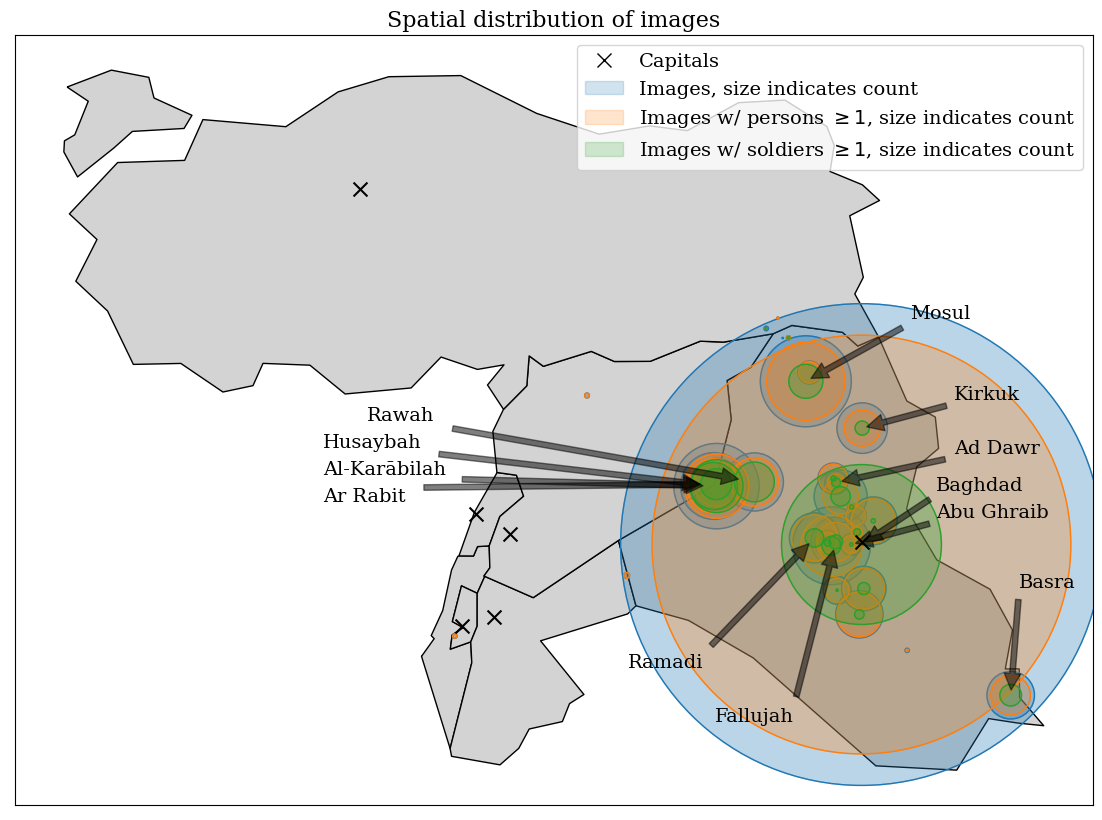

In [28]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], fc = 'none')
coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], alpha = 0.3)

#coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], fc = 'none')
#coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])



# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------


leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq 1$, size indicates count', alpha = 0.2)
leg_uni = mpatches.Patch(color='C2', label='Images w/ soldiers $\geq 1$, size indicates count', alpha = 0.2)
#leg_fir = mpatches.Patch(color='C3', label='Images w/ firearms $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_uni], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map1.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

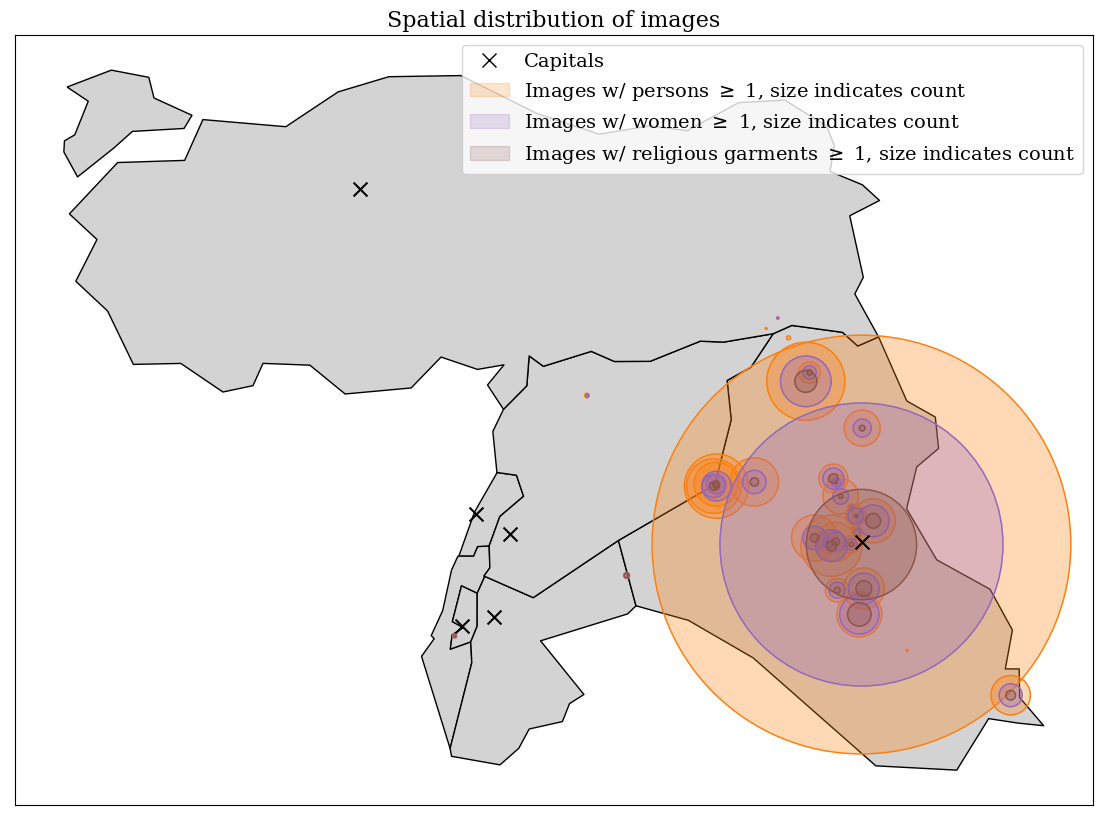

In [29]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], fc = 'none')
coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], alpha = 0.3)

coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], fc = 'none')
coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

#leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_fam = mpatches.Patch(color='C4', label='Images w/ women $\geq$ 1, size indicates count', alpha = 0.2)
leg_gar = mpatches.Patch(color='C5', label='Images w/ religious garments $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_per, leg_fam, leg_gar], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map2.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [30]:
count_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_uni.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_uni, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
1,Kerbala,3,406,0.007389
5,Baqouba,10,1189,0.008410
3,Abu Ghraib,6,251,0.023904
6,Al-Awja,14,494,0.028340
10,Najaf,47,1160,0.040517
15,Habbaniyah,185,3144,0.058842
7,Al Taqaddum,22,342,0.064327
11,Hilla,77,1028,0.074903
13,Kirkuk,104,1325,0.078491
12,Falluja,100,1260,0.079365


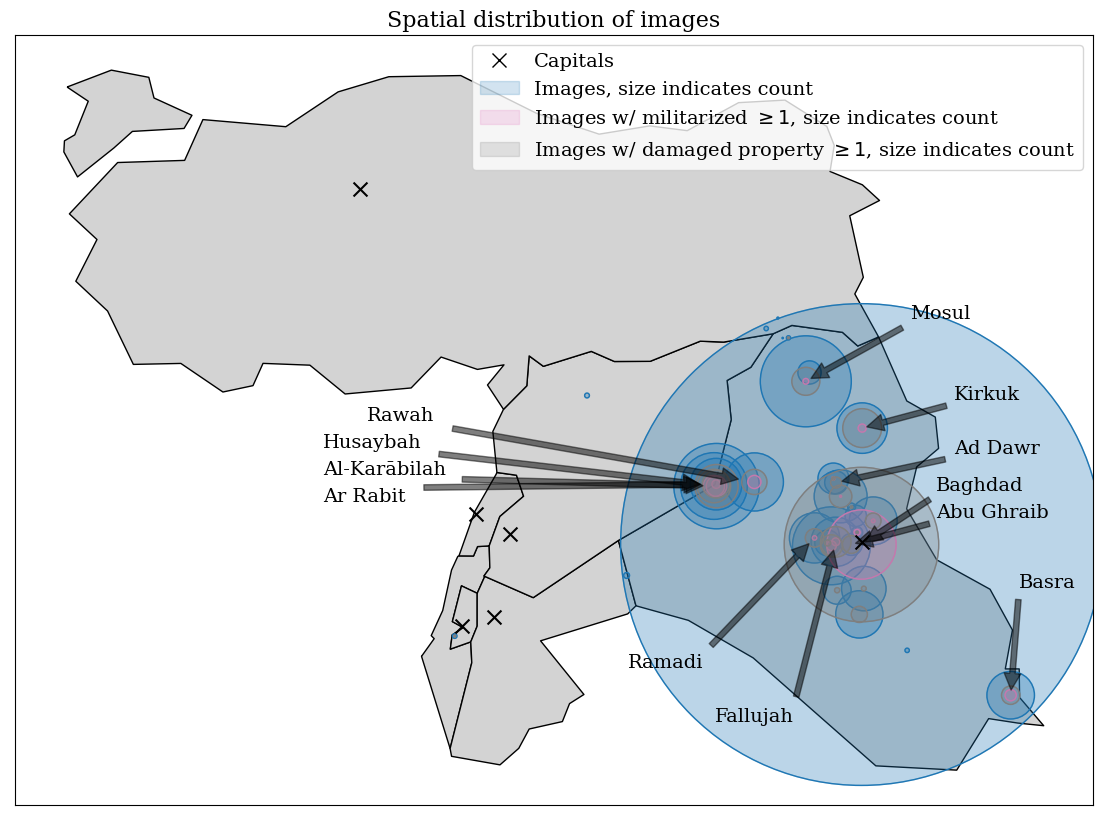

In [31]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], fc = 'none')
coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], alpha = 0.3)

coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], fc = 'none')
coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], alpha = 0.3)

#coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], fc = 'none')
#coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])




# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------






leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_mil = mpatches.Patch(color='C6', label='Images w/ militarized $\geq 1$, size indicates count', alpha = 0.2)
leg_dam = mpatches.Patch(color='C7', label='Images w/ damaged property $\geq 1$, size indicates count', alpha = 0.2)
#leg_pro = mpatches.Patch(color='C8', label='Images w/ protest $\geq$ 1, size indicates count', alpha = 0.2)

ax.legend(handles=[leg_cap, leg_images, leg_mil, leg_dam], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map3.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

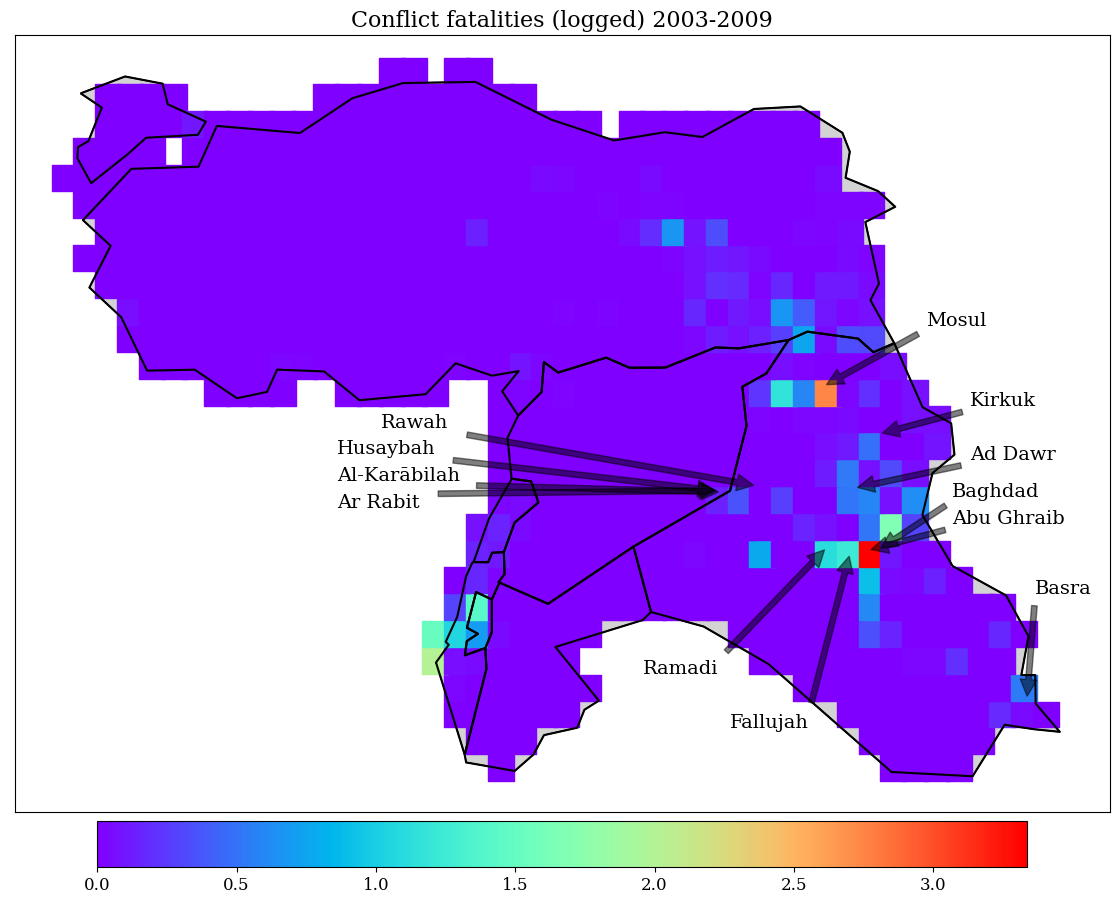

In [32]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'bottom', shrink = 0.8, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)

# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)

# ----------------------------------------------------------------------------------------------

plt.title('Conflict fatalities (logged) 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [ ]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'bottom', shrink = 0.8, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)

# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)

# ----------------------------------------------------------------------------------------------

plt.title('Conflict fatalities (logged) 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4_alt.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

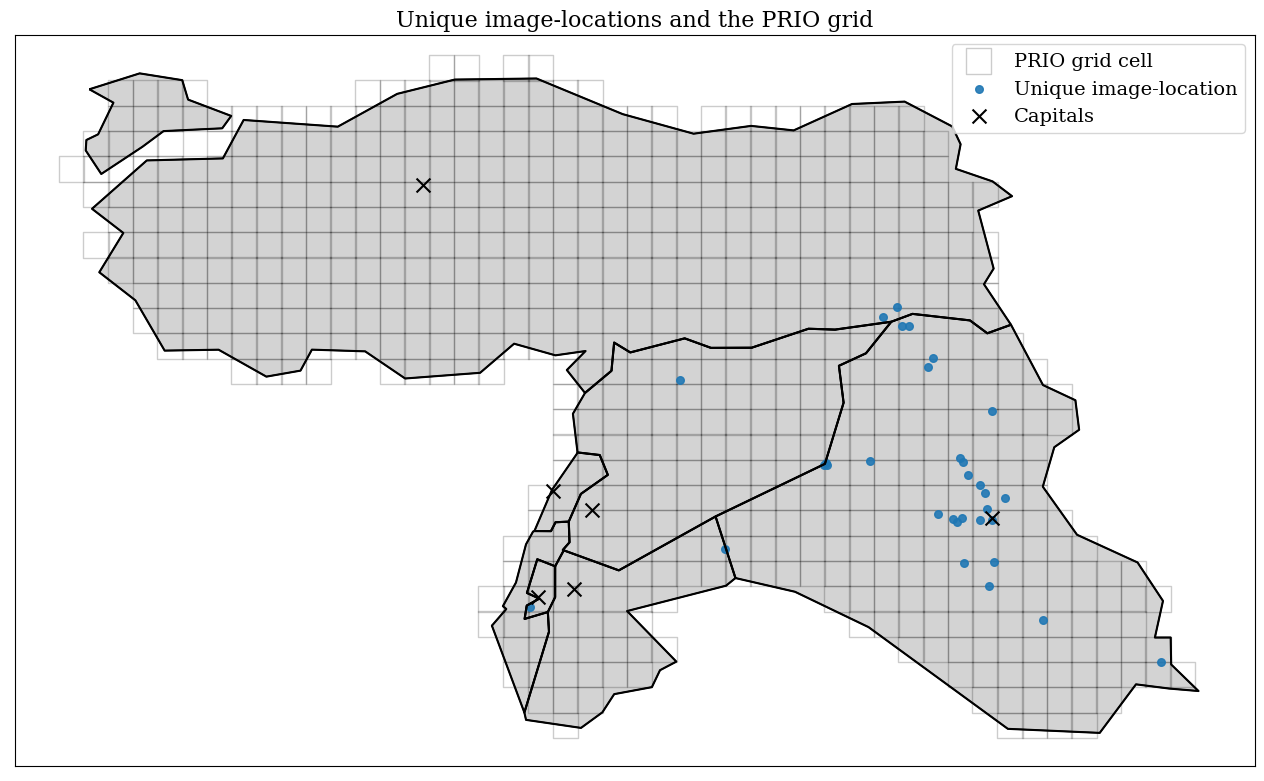

In [33]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize= [16,9.5], aspect = None)

scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 335, color = 'black', fc = 'none', alpha = 0.2, label = 'PRIO grid cell')

#coords.plot(ax=ax, color='red', marker='x', markersize = coords['images'], fc = 'none', aspect = None)
coords.plot(ax=ax, color='C0', marker='o', markersize = 30, alpha = 0.9, aspect = None, label = 'Unique image-location')


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=[16,9.5], aspect = None)
sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100, aspect = None, label = 'Capitals')

plt.title('Unique image-locations and the PRIO grid', fontsize = 16)

plt.xticks([])
plt.yticks([])

plt.legend(fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map0.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

# Ratios tables

In [34]:
count_mil = bodies_df[bodies_df['militarized_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_mil.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_mil, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
0,Samarra,2,1454,0.001376
5,Mosul,17,4294,0.003959
4,other,16,2812,0.005690
2,Baqouba,7,1189,0.005887
3,Ramadi,10,1309,0.007639
1,Al-Awja,6,494,0.012146
10,Habbaniyah,49,3144,0.015585
15,Baghdad,2493,120310,0.020721
7,Falluja,32,1260,0.025397
8,Kirkuk,34,1325,0.025660


In [35]:
count_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_dam.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_dam, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
5,Hilla,12,1028,0.011673
4,Al-Awja,6,494,0.012146
0,Taji,2,65,0.030769
6,Kerbala,14,406,0.034483
7,Al Taqaddum,19,342,0.055556
14,Habbaniyah,252,3144,0.080153
3,Balad,3,32,0.093750
18,Mosul,407,4294,0.094783
24,Baghdad,12375,120310,0.102859
9,Baqouba,127,1189,0.106812


tjek if this the places with no women are bases. ANd what about the one with same amount of women an persons?

# Temporal

In [36]:
cities = bodies_df['city'].unique()

bodies_df = bodies_df.loc[bodies_df['year'] >= 2003, : ]

unique_months  = bodies_df.groupby(['month_id', 'city']).count()
unique_months = unique_months.reindex(pd.MultiIndex.from_product([unique_months.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months = unique_months.reset_index()
unique_months.rename(columns={'person_mean' : 'all'}, inplace= True)

#months_merge = unique_months

In [37]:
# all images with persons on
unique_months_per = bodies_df[bodies_df['person_mean'] >= 1].groupby(['month_id', 'city']).count()
unique_months_per = unique_months_per.reindex(pd.MultiIndex.from_product([unique_months_per.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_per = unique_months_per.reset_index()
unique_months_per.rename(columns={'person_mean' : 'persons'}, inplace= True)

# all images with uniforms on
unique_months_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby(['month_id', 'city']).count() 
unique_months_uni = unique_months_uni.reindex(pd.MultiIndex.from_product([unique_months_uni.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_uni = unique_months_uni.reset_index()
unique_months_uni.rename(columns={'person_mean' : 'uniformed'}, inplace= True)


# all images with uniforms on
unique_months_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby(['month_id', 'city']).count() 
unique_months_dam = unique_months_dam.reindex(pd.MultiIndex.from_product([unique_months_dam.index.levels[0], cities], names=['month_id', 'city']), fill_value = 0)['person_mean']
unique_months_dam = unique_months_dam.reset_index()
unique_months_dam.rename(columns={'person_mean' : 'damaged_property'}, inplace= True)

months_merge = unique_months.merge(unique_months_per, how = 'outer', on = ['month_id', 'city'])
months_merge = months_merge.merge(unique_months_uni, how = 'outer', on = ['month_id', 'city'])
months_merge = months_merge.merge(unique_months_dam, how = 'outer', on = ['month_id', 'city'])

#months_merge.fillna(0, inplace = True)

In [38]:
unique_months['month_id'].unique().shape

(43,)

In [39]:
lwd = [294, 299, 300] # likely wrong dates/months. 
months_merge = months_merge[~months_merge['month_id'].isin(lwd)] # removes 99 obs,

In [40]:
months_merge['month_id'].unique().shape

(40,)

In [95]:
def plot_temporal_cities(feature, months_merge = months_merge):

    colors  = sns.color_palette("hls", 12)

    fig, ax = plt.subplots(figsize=[15,8])

    x = months_merge['month_id'].unique()

    # x1 = months_merge.loc[months_merge['city'] == 'Baghdad','month_id'].reindex(months_merge.index, fill_value=0)
    # x2 = months_merge.loc[months_merge['city'] == 'Falluja','month_id'].reindex(months_merge.index, fill_value=0)
    #x3 = months_merge.loc[months_merge['city'] == 'Ramadi','month_id']

    selected = ['Baghdad','Abu Ghraib', 'Fallujah', 'Husaybah', 'Rawah', 'Karabilah', 'Ar Rabit', 'Ramadi', 'Mosul', 'Basra', 'Kirkuk']

    y1 = months_merge.loc[months_merge['city'] == 'Baghdad',feature].values
    y2 = months_merge.loc[months_merge['city'] == 'Falluja',feature].values
    y3 = months_merge.loc[months_merge['city'] == 'Ramadi',feature].values
    y4 = months_merge.loc[months_merge['city'] == 'Rawah',feature].values
    y5 = months_merge.loc[months_merge['city'] == 'Abu Ghraib',feature].values
    y6 = months_merge.loc[months_merge['city'] == 'Husaybah',feature].values
    y7 = months_merge.loc[months_merge['city'] == 'Ar Rabit',feature].values
    y8 = months_merge.loc[months_merge['city'] == 'Karabilah',feature].values
    y9 = months_merge.loc[months_merge['city'] == 'Mosul',feature].values
    y10 = months_merge.loc[months_merge['city'] == 'Basra',feature].values
    y11 = months_merge.loc[months_merge['city'] == 'Kirkuk',feature].values
    y12 = months_merge.loc[~months_merge['city'].isin(selected), ['month_id', 'all']].groupby('month_id').sum()['all'].values


    alpha = 0.8

    ax.bar(x, y1, width = 1, alpha = alpha, label = 'Baghdad', color = colors[0])
    ax.bar(x, y2, bottom= y1,  width = 1, alpha = alpha, label = 'Fallujah', color = colors[1])
    ax.bar(x, y3, bottom= y1+y2,  width = 1, alpha = alpha, label = 'Ramadi', color = colors[2])
    ax.bar(x, y4, bottom= y1+y2+y3,  width = 1, alpha = alpha, label = 'Rawah', color = colors[3])
    ax.bar(x, y5, bottom= y1+y2+y3+y4,  width = 1, alpha = alpha, label = 'Abu Ghraib', color = colors[4])
    ax.bar(x, y6, bottom= y1+y2+y3+y4+y5,  width = 1, alpha = alpha, label = 'Husaybah', color = colors[5])
    ax.bar(x, y7, bottom= y1+y2+y3+y4+y5+y6,  width = 1, alpha = alpha, label = 'Ar Rabit', color = colors[6])
    ax.bar(x, y8, bottom= y1+y2+y3+y4+y5+y6+y7,  width = 1, alpha = alpha, label = 'Al-Karābilah', color = colors[7])
    ax.bar(x, y9, bottom= y1+y2+y3+y4+y5+y6+y7+y8,  width = 1, alpha = alpha, label = 'Mosul', color = colors[8])
    ax.bar(x, y10, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9,  width = 1, alpha = alpha, label = 'Basra', color = colors[9])
    ax.bar(x, y11, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9+y10,  width = 1, alpha = alpha, label = 'Kirkuk', color = colors[10])
    ax.bar(x, y12, bottom= y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11,  width = 1, alpha = alpha, label = 'Other', color = 'gray')

    #ax.annotate('Abu Ghraib', xy=(280,  np.nanmax(y1+y5)), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
    #ax.annotate('Western Anbar Province', xy=(311, np.nanmax(y6+y7+y8)), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
    #ax.annotate('Abu Ghraib', xy=(280, 2500), xytext=(282, 2800), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)


    if feature == 'all':
        plt.title(f'Temporal distribution of images across locations', fontsize = 16)
        ax.annotate('Baghdad is captured \n by U.S. forces \n April. 2003', xy=(280, 3000), xytext=(292, 3900),
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

        ax.annotate('Operation \n Phantom Fury, \n Nov. 2004', xy=(299, 0), xytext=(297, 2000),
                     arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


        ax.annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, np.nanmax(y6+y7+y8)*1.1), xytext=(320, 6400), 
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

        

    else:
        plt.title(f'Temporal distribution of images across locations \n w/ {feature.replace("_", " ")} $\geq$ 1', fontsize = 16)



    #plt.xlabel('Month ID', fontsize = 14)
    plt.ylabel('Images, count', fontsize = 14)


    ticks_number = np.arange(280, 370, 10)
    ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']
    
    plt.xticks(ticks_number, ticks_name, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim(278, 360)
    plt.ylim(0,np.nanmax(y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12)*1.1)

    plt.legend(fontsize = 14)



    fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend0.png'
    plt.savefig(fig_path, bbox_inches="tight")

    plt.show()

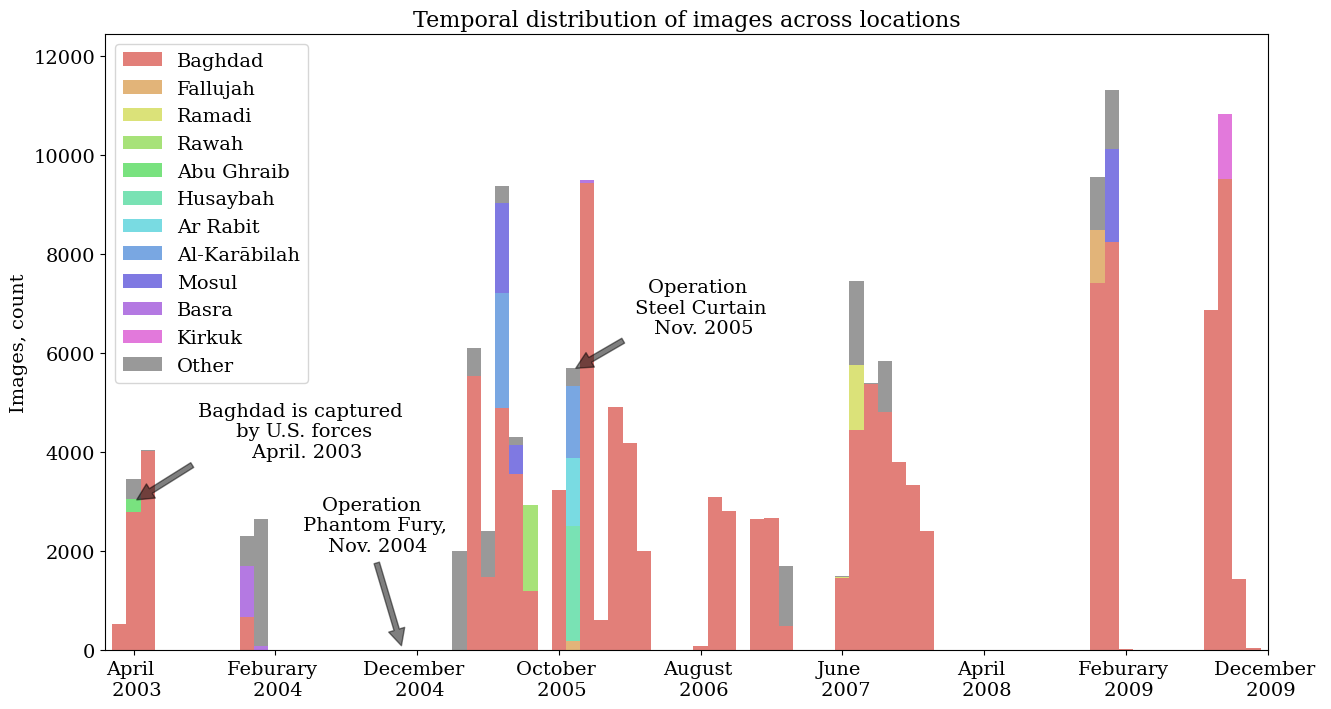

In [96]:
plot_temporal_cities('all')

In [88]:
def plot_temporal_features(months_merge = months_merge):


    fig, ax = plt.subplots(figsize=[15,8])

    month_df = months_merge.groupby('month_id').sum(numeric_only = True).reset_index()

    ax.bar(month_df['month_id'], month_df['all'], width = 1, alpha = 1, label = 'total number of images')
    ax.bar(month_df['month_id'], month_df['persons'],  width = 0.7, alpha = 1, label = 'number of images w/ persons')
    ax.bar(month_df['month_id'], month_df['uniformed'],  width = 0.4, alpha = 1,  label = 'number of images w/ uniformed personelle')

    ax.annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, 5050), xytext=(320, 6400), 
                        arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


    # ax.annotate('Rawah \n Aug. 2005', xy=(308, 2400), xytext=(298, 3500), 
    #                     arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

    plt.hlines(month_df.loc[month_df['month_id'] == 311, 'uniformed'].item(), month_df['month_id'].min(), month_df['month_id'].max(), 
            linestyle = 'dashed', color = 'darkred', alpha = 0.6, label = 'images w/ uniforms under \n Operation Steel Curtain')

    plt.title('Temporal distribution of selected motifs', fontsize = 16)

    #plt.xlabel('Month ID', fontsize = 14)
    plt.ylabel('Images, count', fontsize = 14)

    ticks_number = np.arange(280, 370, 10)
    ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']
    
    plt.xticks(ticks_number, ticks_name, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim(278, 360)

    plt.legend(fontsize = 14)


    fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend1.png'
    plt.savefig(fig_path, bbox_inches="tight")

    plt.show()

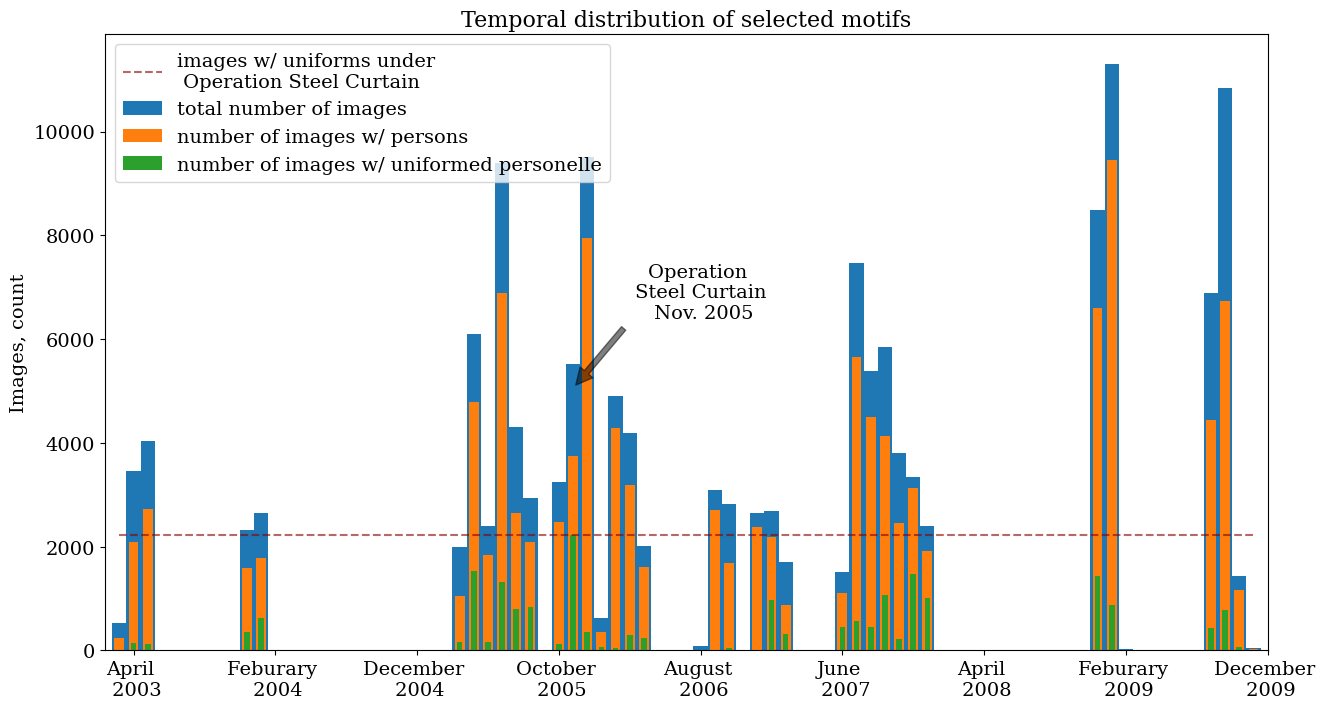

In [89]:
plot_temporal_features()

# CE

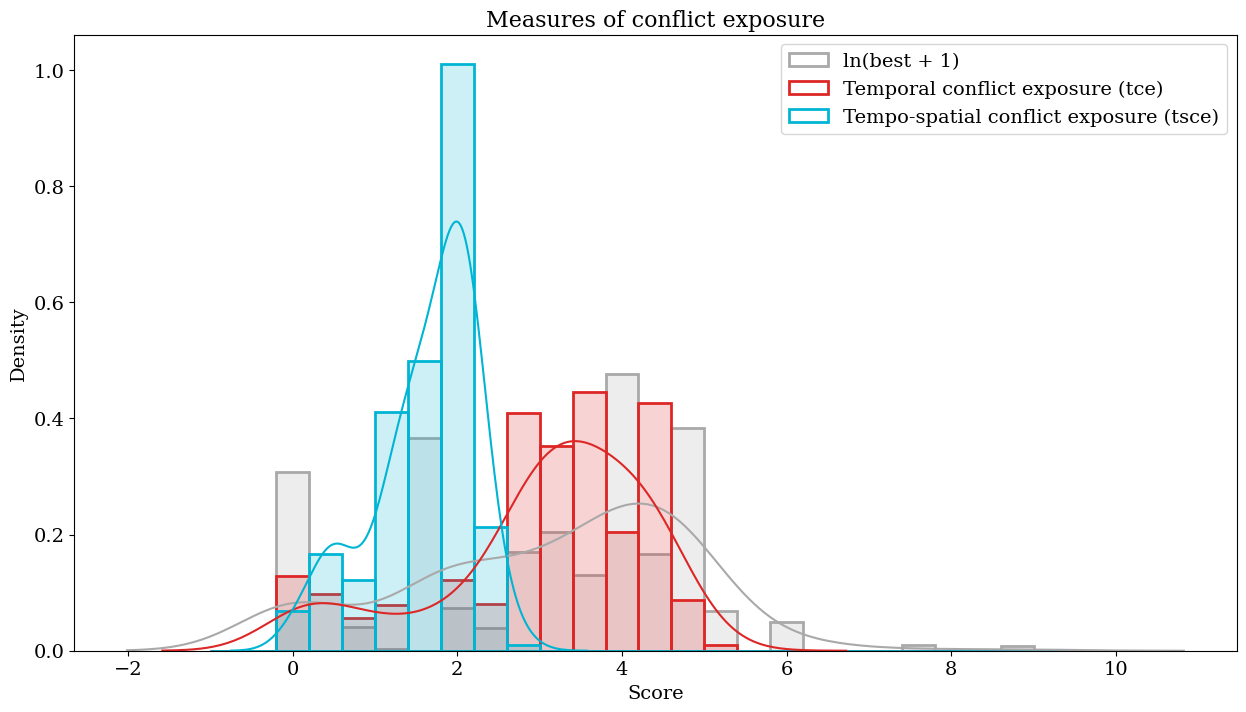

In [45]:
# def std_plot(axs, features, f_range, color):

#     bodies_temp = bodies_df[features].copy()

#     bodies_temp['std'] = bodies_temp[features[1:]].std(axis = 1)
#     bodies_temp

#     std = bodies_temp.groupby(pd.cut(bodies_temp[features[0]], f_range)).mean()['std'].values

#     axs.plot(f_range[:-1], std, 'o-', color=color)

# -----------------------------------------------------------------------------------------------------------------


plt.figure(figsize = [15,8])

ce_range = np.arange(-1,10,0.4)

sns.kdeplot(bodies_df['log_best'].values, color = 'darkgray', bw_method = 0.4)
plt.hist(bodies_df['log_best'].values, color = 'darkgray', density = True, alpha = 0.2, bins = ce_range)
plt.hist(bodies_df['log_best'].values, fc = 'None', ec = 'darkgray',  lw=2, density = True, alpha = 1, bins = ce_range, label = 'ln(best + 1)')

sns.kdeplot(bodies_df['tce'].values, color = '#dd2726', bw_method = 0.4)
plt.hist(bodies_df['tce'].values, color = '#dd2726', density = True, alpha = 0.2, bins = np.arange(-1,10,0.4))
plt.hist(bodies_df['tce'].values, fc = 'None', ec = '#dd2726',  lw=2, density = True, alpha = 1, bins = ce_range, label = 'Temporal conflict exposure (tce)')


sns.kdeplot(bodies_df['tsce'].values, color = '#00b5d4', bw_method = 0.4)
plt.hist(bodies_df['tsce'].values, color = '#00b5d4', density = True, alpha = 0.2, bins = np.arange(-1,10,0.4))
plt.hist(bodies_df['tsce'].values, fc = 'None', ec = '#00b5d4',  lw=2, density = True, alpha = 1, bins = ce_range, label = 'Tempo-spatial conflict exposure (tsce)')



plt.title('Measures of conflict exposure', fontsize = 16)

plt.ylabel('Density', fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel('Score', fontsize = 14)
plt.xticks(fontsize = 14)

plt.legend(fontsize = 14)


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/dist1.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [46]:
bodies_df[['log_best', 'tce', 'tsce']].describe()

,log_best,tce,tsce
count,152009.000000,152009.000000,152009.000000
mean,3.124178,3.056444,1.619667
std,1.673882,1.262126,0.609890
min,0.000000,-0.066720,-0.017091
25%,1.791759,2.810326,1.355943
50%,3.496508,3.333785,1.778572
75%,4.574711,3.934060,2.076977
max,8.814628,5.207269,2.847746


In [47]:
bodies_df[['log_best', 'tce', 'tsce']].corr()

,log_best,tce,tsce
log_best,1.000000,0.838472,0.782929
tce,0.838472,1.000000,0.959981
tsce,0.782929,0.959981,1.000000


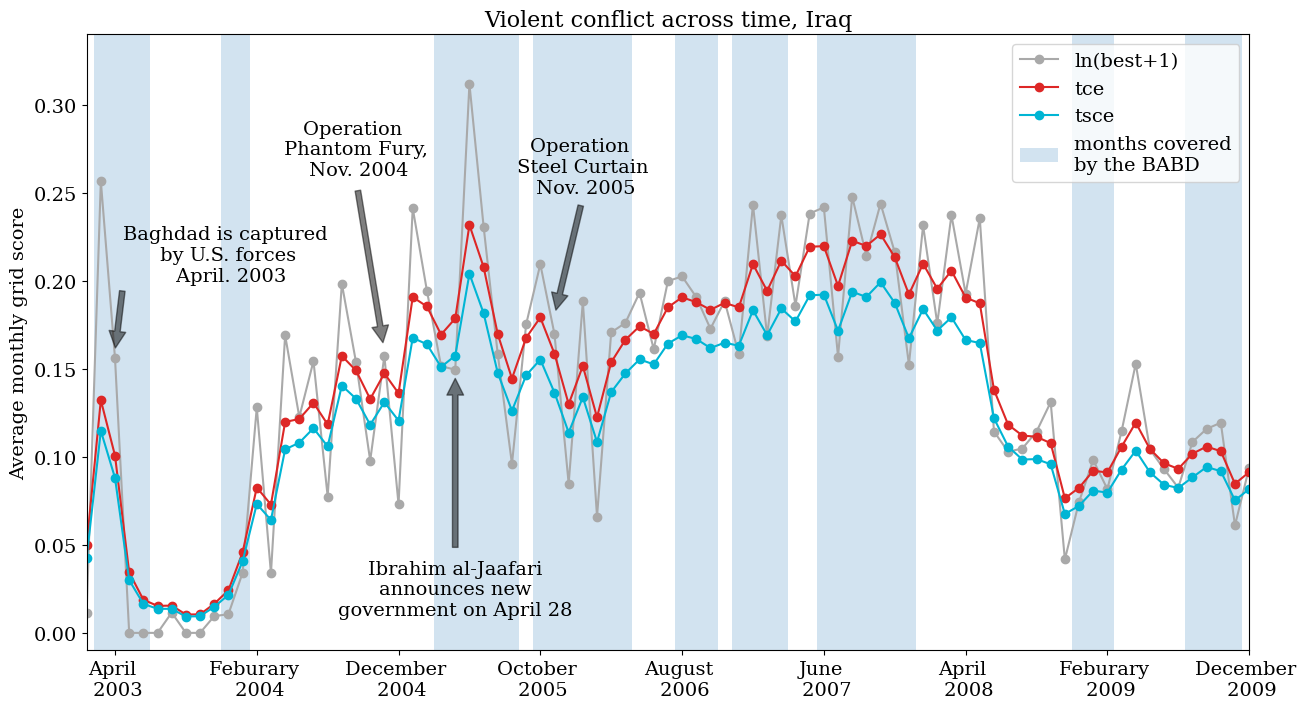

In [92]:
plt.figure(figsize = [15,8])

# Iraq, 652
years = sorted(bodies_df['year'].unique())[:]
sub_iraq  = ucdp_prio[(ucdp_prio['gwno'] == 645) & ucdp_prio['year'].isin(years)]

x = list(sub_iraq.groupby('month_id').mean(numeric_only = True).index)

plt.plot(x,sub_iraq.groupby('month_id').mean(numeric_only = True)['log_best'].values, '-o', color = 'darkgray', label = 'ln(best+1)')
plt.plot(x,np.clip(sub_iraq.groupby('month_id').mean(numeric_only = True)['tce'].values,0,None), '-o', color = '#dd2726', label = 'tce')
plt.plot(x,np.clip(sub_iraq.groupby('month_id').mean(numeric_only = True)['tsce'].values,0,None), '-o', color = '#00b5d4', label = 'tsce')


plt.annotate('Baghdad is captured \n by U.S. forces \n April. 2003', xy=(280, 0.16), xytext=(288, 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

plt.annotate('Operation \n Phantom Fury, \n Nov. 2004', xy=(299, 0.16), xytext=(297, 0.26),
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


plt.annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, 0.18), xytext=(313, 0.25), 
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


plt.annotate('Ibrahim al-Jaafari\nannounces new\ngovernment on April 28', xy=(304, 0.15), xytext=(304, 0.01), 
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')


plt.bar(months_merge['month_id'].unique(), 0.4, width = 1, bottom = -0.01, color = 'C0', alpha  = 0.2, label = 'months covered\nby the BABD')
#plt.bar(bodies_df['month_id'].unique(), 0.4, width = 1, bottom = -0.01, color = 'C1', alpha  = 0.2, label = 'months covered\nby the BABD')
# so a couple of months have been discarded bacouse you are not sure..

ticks_number = np.arange(280, 370, 10)
ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']

plt.xticks(ticks_number, ticks_name, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Average monthly grid score', fontsize = 14)
plt.xlim(278, 360)
plt.ylim(-0.01, 0.34)

plt.legend(fontsize = 14, loc = 'upper right')

plt.title(f'Violent conflict across time, Iraq', fontsize = 16)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend2.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

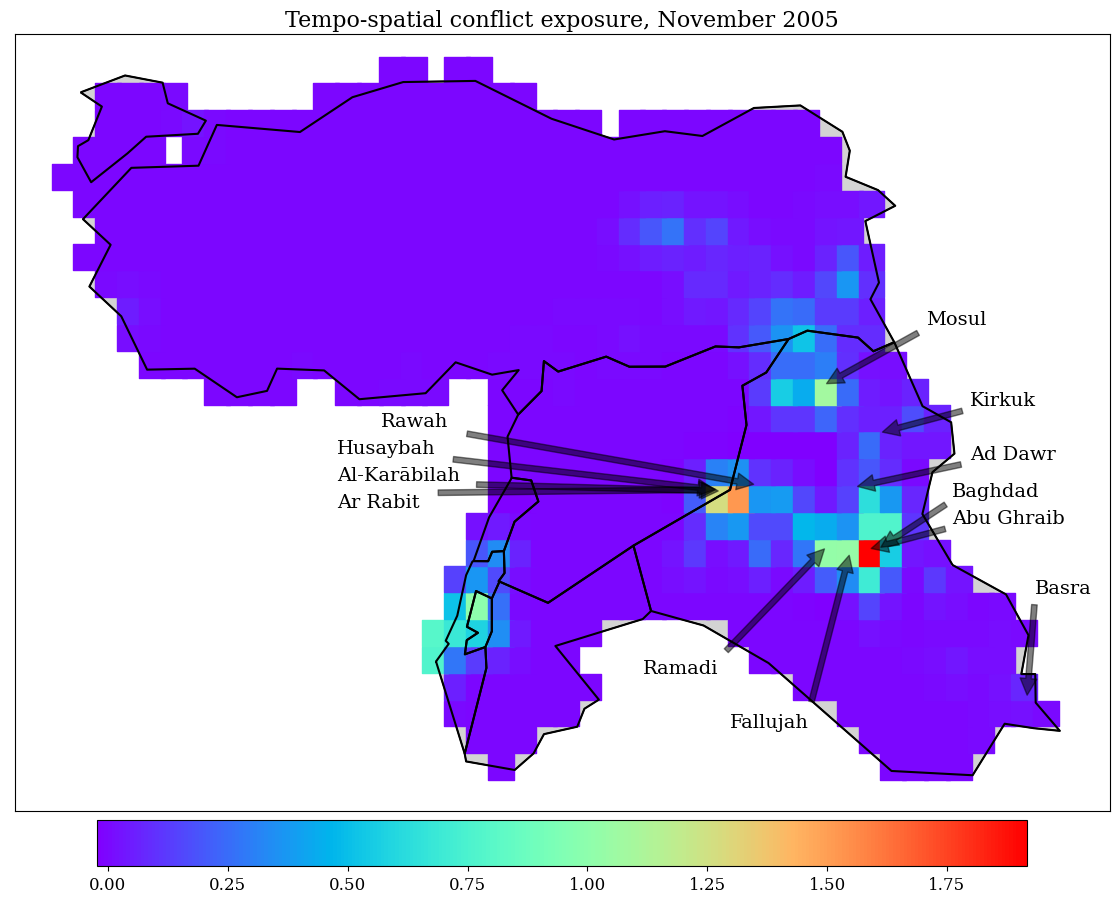

In [49]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

#years = sorted(bodies_df['year'].unique())

#sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()

# these two are the same:
sub_up = ucdp_prio.loc[(ucdp_prio['year'] == 2005) & (ucdp_prio['month'] == 11 ) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()
#sub_up = ucdp_prio.loc[ucdp_prio['month_id'] == 311,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['tsce'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'bottom', shrink = 0.8, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)

ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)


#plt.title('Tempo-spatial conflict exposure, 2003-2009', fontsize = 16)
plt.title('Tempo-spatial conflict exposure, November 2005', fontsize = 16)


plt.xticks([])
plt.yticks([])


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map5.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

# a bit messy things to check stuff:

In [50]:
bodies_df['month_id'] == 304

0         False
1         False
2         False
3         False
4         False
          ...  
152183    False
152184    False
152185    False
152186    False
152187    False
Name: month_id, Length: 152009, dtype: bool

In [51]:
bodies_df.groupby('month_id').mean(numeric_only = True)[['mass_protest_mean']].sort_values('mass_protest_mean', ascending = False).reset_index()

,month_id,mass_protest_mean
0,299,0.113897
1,312,0.039935
2,327,0.025739
3,304,0.007821
4,305,-0.000668
5,311,-0.026898
6,310,-0.039284
7,314,-0.039307
8,315,-0.060322
9,325,-0.061527


In [52]:
bodies_df.groupby('month_id').mean(numeric_only = True)[['militarized_mean']].sort_values('militarized_mean', ascending = False).reset_index()

,month_id,militarized_mean
0,299,0.851779
1,327,0.557791
2,336,0.502065
3,335,0.488107
4,313,0.427848
5,311,0.395648
6,359,0.395000
7,320,0.379698
8,325,0.330617
9,330,0.308561


In [53]:
bodies_df.groupby('month_id').mean(numeric_only = True)[['damaged_property_mean']].sort_values('damaged_property_mean', ascending = False).reset_index()

,month_id,damaged_property_mean
0,299,1.557004
1,327,1.234938
2,320,1.082151
3,359,1.014540
4,311,0.544224
5,336,0.528994
6,313,0.522466
7,289,0.475852
8,325,0.471833
9,348,0.427708


In [54]:
bodies_df['month_id'].unique().shape

(43,)

In [55]:
bodies_df_full['month_id'].unique().shape

(50,)

In [56]:
cut_months = set.difference(set(bodies_df_full['month_id'].unique()),set(bodies_df['month_id'].unique()))

In [57]:
sub_df = bodies_df_full.groupby('month_id').count().reset_index()
sub_df[sub_df['month_id'].isin(cut_months)]

,month_id,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,...,pasture_ih_observed,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean
0,241,125,125,125,125,125,125,125,125,125,...,125,125,125,125,125,125,125,125,125,125
1,257,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
8,292,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
39,338,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
40,345,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
44,352,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
49,361,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [58]:
sub_df[sub_df['month_id'].isin(cut_months)].sum()

month_id             2186
person_mean           179
person_median         179
person_fasterR50      179
person_fasterR101     179
                     ... 
urban_ih_observed     179
cmr_mean              179
imr_mean              179
mountains_mean        179
ttime_mean            179
Length: 194, dtype: int64

In [59]:
bodies_df_full[bodies_df_full['month_id'].isin(cut_months)][['year', 'month', 'month_id']].groupby('month_id').mean().reset_index().sort_values('month_id')

,month_id,year,month
0,241,2000.0,1.0
1,257,2001.0,5.0
2,292,2004.0,4.0
3,338,2008.0,2.0
4,345,2008.0,9.0
5,352,2009.0,4.0
6,361,2010.0,1.0


In [60]:
sus_months = [294, 299, 300]

In [61]:
bodies_df_full[bodies_df_full['month_id'].isin(sus_months)].groupby('month_id').count()

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,pasture_ih_observed,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean
month_id,,,,,,,,,,,,,,,,,,,,,
294,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
299,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
300,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


In [62]:
bodies_df_full[bodies_df_full['month_id'].isin(sus_months)].groupby('month_id').count().sum()

person_mean          40
person_median        40
person_fasterR50     40
person_fasterR101    40
person_fasterX101    40
                     ..
urban_ih_observed    40
cmr_mean             40
imr_mean             40
mountains_mean       40
ttime_mean           40
Length: 193, dtype: int64

In [63]:
bodies_df_full[bodies_df_full['month_id'].isin(sus_months)][['year', 'month', 'month_id']].groupby('month_id').mean().reset_index().sort_values('month_id')

,month_id,year,month
0,294,2004.0,6.0
1,299,2004.0,11.0
2,300,2004.0,12.0


In [64]:
bodies_df[bodies_df['city'] == 'Falluja']['month_id'].unique()

array([311, 348])

In [65]:
219/152188

0.0014390096459642023

In [66]:
pd.to_timedelta(24*3600000000000)

Timedelta('1 days 00:00:00')

In [67]:
294, 299, 300

(294, 299, 300)

In [68]:
bodies_df_full

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,pasture_ih_observed,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.90000,1020.000,0.0,58.67639
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.87917,1014.583,0.0,415.26140
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,False,15.87917,1014.583,0.0,415.26140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152183,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152184,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170
152186,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,False,False,False,False,True,False,15.90000,1020.000,0.0,168.32170


In [69]:
for i in bodies_df.columns:
    print(i)

person_mean
person_median
person_fasterR50
person_fasterR101
person_fasterX101
person_retinaR50
person_retinaR101
child_mean
child_median
child_retinaR50
child_retinaR101
male_mean
male_median
male_fasterR50
male_fasterR101
male_fasterX101
male_retinaR50
male_retinaR101
adult_mean
adult_median
adult_fasterR50
adult_fasterR101
adult_fasterX101
adult_retinaR50
adult_retinaR101
youth_mean
youth_median
youth_retinaR50
youth_retinaR101
falgIRQ_mean
falgIRQ_median
falgIRQ_fasterR50
falgIRQ_fasterR101
falgIRQ_fasterX101
falgIRQ_retinaR50
falgIRQ_retinaR101
female_mean
female_median
female_retinaR50
female_retinaR101
religiousGarmentFemale_mean
religiousGarmentFemale_median
religiousGarmentFemale_retinaR50
religiousGarmentFemale_retinaR101
uniformed_mean
uniformed_median
uniformed_fasterR50
uniformed_fasterR101
uniformed_fasterX101
uniformed_retinaR50
uniformed_retinaR101
firearm_mean
firearm_median
firearm_fasterR50
firearm_fasterR101
firearm_fasterX101
firearm_retinaR50
firearm_retinaR101
fl

In [97]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4_JACOB.pkl', 'rb') as file:
    bodies_df_small = pickle.load(file)

In [101]:
bodies_df_small['longitude_full']


0         44.378799
1         44.378799
2         44.378799
3         41.037860
4         41.046437
            ...    
152183    44.152789
152184    44.152789
152185    44.152789
152186    44.152789
152187    44.152789
Name: longitude_full, Length: 152188, dtype: float64

In [110]:
bodies_df_full['bdist3'].max()

215.4322

In [108]:
bodies_df_full['time created'].min()

'000000+0300'

In [103]:
for i in bodies_df_full.columns:
    print(i)

person_mean
person_median
person_fasterR50
person_fasterR101
person_fasterX101
person_retinaR50
person_retinaR101
child_mean
child_median
child_retinaR50
child_retinaR101
male_mean
male_median
male_fasterR50
male_fasterR101
male_fasterX101
male_retinaR50
male_retinaR101
adult_mean
adult_median
adult_fasterR50
adult_fasterR101
adult_fasterX101
adult_retinaR50
adult_retinaR101
youth_mean
youth_median
youth_retinaR50
youth_retinaR101
falgIRQ_mean
falgIRQ_median
falgIRQ_fasterR50
falgIRQ_fasterR101
falgIRQ_fasterX101
falgIRQ_retinaR50
falgIRQ_retinaR101
female_mean
female_median
female_retinaR50
female_retinaR101
religiousGarmentFemale_mean
religiousGarmentFemale_median
religiousGarmentFemale_retinaR50
religiousGarmentFemale_retinaR101
uniformed_mean
uniformed_median
uniformed_fasterR50
uniformed_fasterR101
uniformed_fasterX101
uniformed_retinaR50
uniformed_retinaR101
firearm_mean
firearm_median
firearm_fasterR50
firearm_fasterR101
firearm_fasterX101
firearm_retinaR50
firearm_retinaR101
fl

In [ ]:
'person_mean', 'male_mean', 'falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean', 'uniformed_mean', 'firearm_mean',
      'flagUS_mean', 'militaryVehicle_mean',

In [99]:
cf = [ 'emotions_t2_mean','formal_mean', 'privat_mean', 'urban_mean', 'militarized_mean',
      'damaged_property_mean', 'public_mean', 'emotions_t1_mean', 'mass_protest_mean', 'rural_mean']

In [100]:
len(cf)

19

In [ ]:
'img_id',  'publication', 'year', 'month',
       'distance_days', 'longitude_full', 'latitude_full', 'month_id', 'gid',
       'xcoord', 'ycoord', 'gwno', 'city', 'city_id', 'deaths_a', 'deaths_b',
       'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low', 'log_best',
       'log_low', 'log_high', 'agri_ih', 'barren_ih', 'bdist3', 'capdist',
       'excluded', 'gcp_mer', 'gcp_ppp', 'irrig_sum', 'nlights_calib_mean',
       'nlights_mean', 'pasture_ih', 'petroleum_y', 'pop_gpw_sd',
       'pop_gpw_sum', 'prec_gpcp', 'urban_ih', 'cmr_mean', 'imr_mean',
       'mountains_mean', 'ttime_mean', 'tce', 'tsce',